In [2]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2

import tensorflow as tf
from keras import backend as K

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
with zipfile.ZipFile("../input/data-science-bowl-2018/stage1_train.zip",'r') as z:
    z.extractall("stage1_train")

with zipfile.ZipFile("../input/data-science-bowl-2018/stage2_test_final.zip",'r') as z:
    z.extractall("stage2_test_final")

In [5]:
train_path = 'stage1_train/'
test_path = 'stage2_test_final/'

In [6]:
train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)

First, let's create empty tensors for future images

In [7]:
X_train = np.zeros((len(train_dir), 256, 256, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_dir), 256, 256, 1), dtype=bool)

X_test = np.zeros((len(test_dir), 256, 256, 3), dtype=np.uint8)

The directory structure looks like each **Spot Nuclei** has its own folder.

The folder with **id Spot Nuclei** contains two folders: **images** and **masks**

images contains the original **Spot Nuclei image**. We need to write it **into a pre-created tensor X**

masks contains several images with **different parts of the masks**. We need to **merge all the masks into one image** using **np.maximum**. Further, just as with the original image, write to the **pre-created tensor Y**

We will **compress all images** to a size of **256x256x3**, however, we will set the size of **mask images** to **256x256x1**, since it makes no sense for us to store them in **rgb format**

In [8]:
%%time
from tqdm import tqdm 
for i, name in tqdm(enumerate(train_dir)):
    path = train_path + name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real,(256,256))
    X_train[i] = img_real
    
    img_segment_full = np.zeros((256, 256 , 1), dtype=bool)
    segment_path = path+'/masks/'
    for name in os.listdir(segment_path):
        img_segment = cv2.imread(segment_path + name, 0)
        img_segment = cv2.resize(img_segment, (256, 256))
        img_segment = np.expand_dims(img_segment, axis=-1)
        img_segment_full = np.maximum(img_segment_full, img_segment)
    
    Y_train[i] = img_segment_full

670it [03:23,  3.28it/s]

CPU times: total: 1min 7s
Wall time: 3min 24s


In [9]:
%%time
for i, name in tqdm(enumerate(test_dir)):
    path = test_path + name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real, (256,256))
    X_test[i] = img_real

CPU times: total: 25.8 s
Wall time: 5min 8s


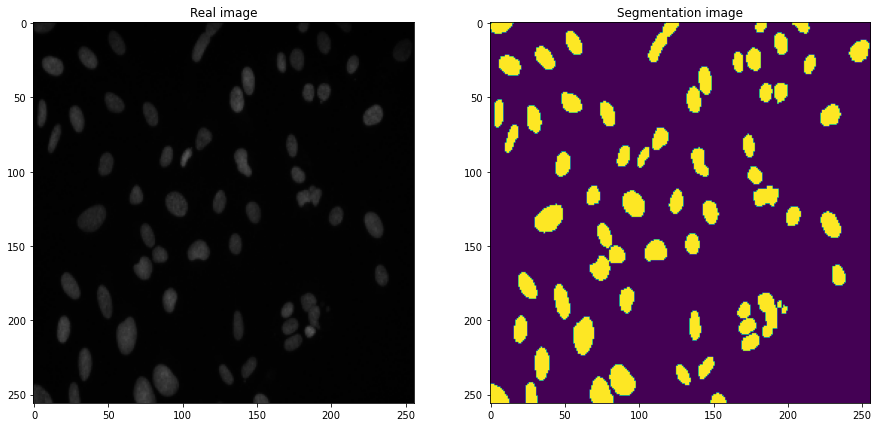

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(X_train[45])
plt.title('Real image')
plt.subplot(122)
plt.imshow(Y_train[45])
plt.title('Segmentation image');

Data preprocessing

**U-net** does not require a large amount of data, as for example for the classification task, however, there are only **670 data** in the train, I believe that **augmentation** here can improve the segmentation result

In [11]:
aug_gen_args = dict(shear_range = 0.2,
                    zoom_range = 0.2,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect'
                   )

X_train_gen = ImageDataGenerator(**aug_gen_args)
y_train_gen = ImageDataGenerator(**aug_gen_args)
X_val_gen = ImageDataGenerator()
y_val_gen = ImageDataGenerator()

To begin with, let's demonstrate on one image what augmentation looks like.

It is important to set the **seed** and **shuffle=False** in order for the **original augmented images** to match the **segmented augmented images**.

In [12]:
aug_image_real = X_train[45].reshape((1,)+X_train[1].shape)
aug_image_seg = Y_train[45].reshape((1,)+Y_train[1].shape)

In [13]:
aug_image_real_check = X_train_gen.flow(aug_image_real, batch_size=1, seed=17, shuffle=False)
aug_image_seg_check = y_train_gen.flow(aug_image_seg, batch_size=1, seed=17, shuffle=False)

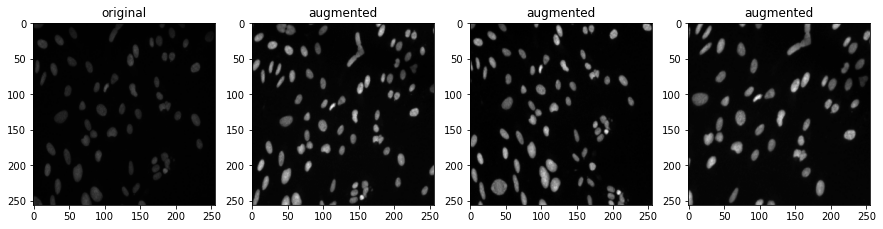

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(X_train[45])
plt.title("original")
i=2
for batch in aug_image_real_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

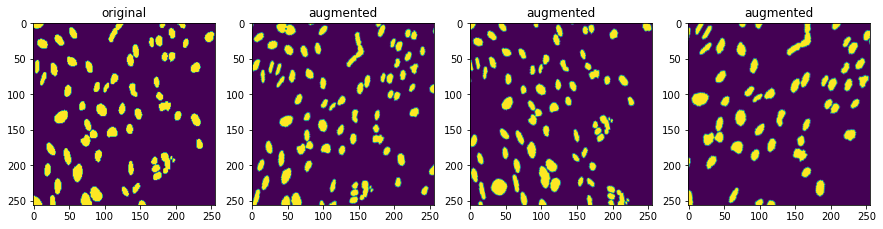

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(Y_train[45])
plt.title("original")
i=2
for batch in aug_image_seg_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

Looks good, now let's split **X_train** into **2 parts**: **train** and **val**. For val of the selection, select **0.1 data size**

Next, **apply the augmentation generators** to the train data; no augmentation will be performed for the val data

Since we need to do augmentation for original images and segmented images, then we **need to combine the generators** into one using the **zip()**

In [16]:
train, val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [17]:
X_train_gen.fit(train, augment=True, seed=45)
y_train_gen.fit(y_train, augment=True, seed=45)
X_val_gen.fit(val, seed=45)
y_val_gen.fit(y_val, seed=45)

X_train_generator = X_train_gen.flow(train, batch_size=16, seed=45, shuffle=False)
y_train_generator = y_train_gen.flow(y_train, batch_size=16, seed=45, shuffle=False)
X_val_generator = X_val_gen.flow(val, batch_size=16, seed=45, shuffle=False)
y_val_generator = y_val_gen.flow(y_val, batch_size=16, seed=45, shuffle=False)

train_generator = zip(X_train_generator, y_train_generator)
val_generator = zip(X_val_generator, y_val_generator)

### IoU metric

![](https://images.viblo.asia/1f53756b-5271-4d27-824c-180043f47ebe.png)

To calculate **mean_iou**, we calculate the **IoU for each threshold using a loop**, passing **t_y_pred** of type **float32**

In [18]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

In [19]:
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

### Dice loss

In [20]:
def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + 1) / (union + 1), axis=0)
    return 1. - dice

#  <center>U-net model training</center>

---------------------

In [21]:
inputs = Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = UpSampling2D(size=(2,2))(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = UpSampling2D(size=(2,2))(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = UpSampling2D(size=(2,2))(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = UpSampling2D(size=(2,2))(conv8)
up9 = concatenate([up9, conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = models.Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])

using **optimizer='Adam'** as the most basic and recommended, but for **better accuracy**, I **lowered the learning_rate**

**loss='dice_loss'** we defined it with the **dice_loss** function earlier

**metrics='mean_iou'** we defined it with the **mean_iou** function earlier

In [4]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_60[0][0]']              
                                )                                                           

                                )                                                                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_77[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_79 (Conv2D)             (None, 256, 256, 1)  33          ['conv2d_78[0][0]']              
                                                                                                  
Total params: 10,206,465
Trainable params: 10,206,465
Non-trainable params: 0
__________________________________________________________________________________________________


In [43]:
#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss')]

#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, callbacks=callbacks)




history = model.fit(train_generator,
                    steps_per_epoch=len(train)/8,
                    validation_data=val_generator,
                    validation_steps=len(val)/8,
                    epochs=75,callbacks=callbacks
                   )

In [44]:
model.save("unet2_model.h5")

In [22]:
model = tf.keras.models.load_model("unet2_model.h5")

#   <center>Result on train/val data</center> 

In [ ]:
train_pred = model.predict(train, verbose = 1)
val_pred = model.predict(val, verbose=1)

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(train[45])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_train[1]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(train_pred[1]))
plt.title('Predicted  image');

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(val[45])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_val[3]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(val_pred[3]))
plt.title('Predicted  image');

Great, it looks like the neural network really works, now let's **predict** the result for **X_test data**.

#   <center>Result on test data</center>

In [ ]:
test_pred = model.predict(X_test, verbose=1)

In [ ]:
plt.figure(figsize=(15, 32))
for i in range(421, 429):
    plt.subplot(i)
    if i % 2!=0:
        plt.imshow(X_test[i])
        plt.title('Original image')
    else:
        plt.imshow(np.squeeze(test_pred[i-1]))
        plt.title('Predicted image')